In [3]:
## Setup

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.nn.utils.parametrizations import spectral_norm
from pathlib import Path
import time

from torch.utils.data import Dataset

from utils import *

In [ ]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

workers = 2
batch_size = 128
image_size = 256
nc = 1 # Number of channels
nz = 100 # Size of latent vector
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 1001
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
ngpu = 1 # Number of available gpus

Random Seed:  999


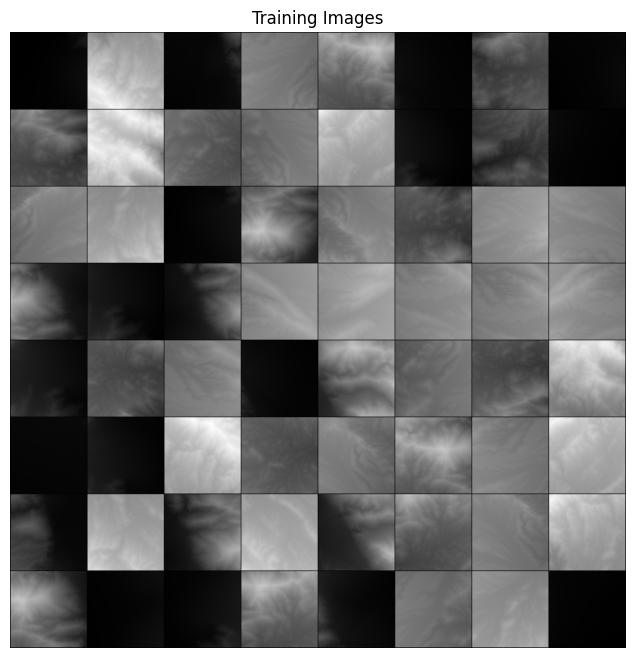

In [ ]:
## Provide the path to the file
dataset = np.load("death_valley_size_128_zoom_0.1.npy")
dataset = np.transpose(dataset[..., np.newaxis].astype('float32'), (0,3,1,2))

## Dummy data to check whether everything's working
# dataset = np.random.rand(15000, 1, 128, 128).astype(np.float32) * 1000


dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())

dataset = torch.from_numpy(dataset)

class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        heightmap = self.data[idx]
        
        if self.transform:
            heightmap = self.transform(heightmap)
        return heightmap



# Transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(
            [0.5 for _ in range(nc)], [0.5 for _ in range(nc)]
        )
    
    ])

# Create dataloader
dataset = CustomImageDataset(dataset, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
## Weight initialization

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


### Final Generator 256x256
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(nz, ngf * 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(ngf * 16, ngf * 8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(ngf * 8, ngf * 4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ngf * 4, ngf * 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ngf * 2, ngf * 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ngf * 1, int(ngf * 0.5), kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(int(ngf * 0.5)),
            nn.ReLU(True),
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(int(ngf * 0.5), int(ngf * 0.25), kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(int(ngf * 0.25)),
            nn.ReLU(True),
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(int(ngf * 0.25), nc, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)

### 


# Create the generator
netG = Generator(ngpu).to(device)

# Initialize the weights
netG.apply(weights_init)

# Print the model
print(netG)

summary(netG, (100, 1, 1))

## Discriminator 256x256 final

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            spectral_norm(nn.Conv2d(nc, int(ndf * 0.5), 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            spectral_norm(nn.Conv2d(int(ndf * 0.5), ndf * 1, 4, 2, 1, bias=False)),
            # nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            # nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            # nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            # nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False)),
            # nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            

            # state size. (ndf*8) x 4 x 4
            spectral_norm(nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False)),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Initialize the weights
netD.apply(weights_init)

# Print the model
print(netD)

summary(netD, (1, 256, 256))

Generator(
  (main): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(100, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Upsample(scale_factor=2.0, mode=nearest)
    (9): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Upsample(scale_factor=2.0, mode=nearest)
    (13): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1

In [ ]:
## Training setup

# Loss function(s)
BCE_stable = torch.nn.BCEWithLogitsLoss()

# Finxed noise to visualize the progress made by the networks
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Labels
real_label = 0.9
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
epoch_start = 0
continue_training = False
if continue_training:
    ## Specift path to the model checkpoint to continue training
    checkpoint = torch.load("Relativistic Loss Functions/models/RaGAN_spec_label_up_deconv_200.pth")
    
    netG = Generator(ngpu).to(device)
    netG.load_state_dict(checkpoint["state_dict_gen"])
    
    netD = Discriminator(ngpu).to(device)
    netD.load_state_dict(checkpoint["state_dict_disc"])
    
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
    optimizerD.load_state_dict(checkpoint["optimizer_disc"])
    
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))
    optimizerG.load_state_dict(checkpoint["optimizer_gen"])
    
    epoch_start = checkpoint["epoch"]

In [ ]:
## Path to save model checkpoints, losses and visualizations
base_path = Path("Relativistic Loss Functions/final")
models_path = base_path / "models"
if not os.path.isdir(models_path):
    os.makedirs(models_path)
model_name = "RaGAN_spec_label_up_deconv_256x256_{:04d}.pth"

In [ ]:
evaluate_gan = EvaluateGAN(device=device, features=2048)

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
evaluate_gan.calculate_statistics_for_real(dataloader)

100%|██████████| 118/118 [00:15<00:00,  7.54it/s]


In [ ]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_real_accuracy = []
D_fake_accuracy = []
FID_metrics = []
KID_metrics = []

iters = 0

print("Starting Training Loop...")
# For each epoch
start = time.time()
for epoch in range(epoch_start, num_epochs+epoch_start):
    if epoch % 100 == 0:
        fid_metric, kid_metric = evaluate_gan.evaluate(generator=netG, num_samples=len(dataset), device=device)
        FID_metrics.append(fid_metric)
        KID_metrics.append(kid_metric)
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        netD.zero_grad()
        real_cpu = data.to(device)
        
        b_size = real_cpu.size(0)
        label_real_vec = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output_real = netD(real_cpu).view(-1)
        
        D_real_accuracy.append(nn.Sigmoid()(output_real).mean().item())
        D_x = output_real.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        
        label_fake_vec = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        output_fake = netD(fake.detach()).view(-1)
        D_G_z1 = output_fake.mean().item()
        
        errD = (BCE_stable(output_real - torch.mean(output_fake), label_real_vec) + BCE_stable(output_fake - torch.mean(output_real), label_fake_vec))/2
        errD.backward()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        output_fake = netD(fake).view(-1)
        output_real = netD(real_cpu).view(-1)
        
        errG = (BCE_stable(output_real - torch.mean(output_fake), label_fake_vec) + BCE_stable(output_fake - torch.mean(output_real), label_real_vec))/2
        errG.backward()
        
        D_G_z2 = output_fake.mean().item()
        optimizerG.step()
        
        D_fake_accuracy.append(nn.Sigmoid()(output_fake).mean().item())

        # Output training stats 
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs+epoch_start, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1
    print(time.time() - start)

    if epoch % 10 == 0: 
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake[:9], padding=2, normalize=True, nrow=3))
        
    if epoch % 100 == 0:
        state = {'epoch': epoch + 1,
                    'state_dict_disc': netD.state_dict(),
                    'optimizer_disc': optimizerD.state_dict(),
                    'state_dict_gen': netG.state_dict(),
                    'optimizer_gen': optimizerG.state_dict()}
        torch.save(state, models_path / model_name.format(epoch))

Starting Training Loop...



100%|██████████| 117/117 [00:23<00:00,  5.06it/s]


current FID / previous FID [(17.2114/inf), ratio: (0.0000)]
current KID / previous KID [(14.497179985046387, 0.6471333503723145)/(inf, inf)]

[0/1001][0/118]	Loss_D: 0.6924	Loss_G: 0.8099	D(x): 0.0058	D(G(z)): 0.0040 / -0.0475
[0/1001][50/118]	Loss_D: 0.7240	Loss_G: 0.9614	D(x): 0.7471	D(G(z)): 0.7047 / 0.6423
[0/1001][100/118]	Loss_D: 0.6938	Loss_G: 0.6960	D(x): 0.0811	D(G(z)): 0.0814 / 0.0744
91.3847758769989
[1/1001][0/118]	Loss_D: 0.6921	Loss_G: 0.7154	D(x): 0.1833	D(G(z)): 0.1606 / 0.1144
[1/1001][50/118]	Loss_D: 0.6855	Loss_G: 0.7097	D(x): 0.0359	D(G(z)): 0.0177 / 0.0727
[1/1001][100/118]	Loss_D: 0.6888	Loss_G: 0.7023	D(x): -0.0083	D(G(z)): -0.0195 / -0.0139
161.73540472984314
[2/1001][0/118]	Loss_D: 0.6991	Loss_G: 0.6927	D(x): 0.0252	D(G(z)): 0.0342 / 0.0175
[2/1001][50/118]	Loss_D: 0.6989	Loss_G: 0.6933	D(x): 0.1718	D(G(z)): 0.1818 / 0.1716
[2/1001][100/118]	Loss_D: 0.6874	Loss_G: 0.7002	D(x): -0.0170	D(G(z)): -0.0298 / -0.0358
231.17596054077148
[3/1001][0/118]	Loss_D: 0.7835	

2059.3926610946655
[29/1001][0/118]	Loss_D: 0.6924	Loss_G: 0.6940	D(x): -0.0015	D(G(z)): -0.0032 / -0.0040
[29/1001][50/118]	Loss_D: 0.6900	Loss_G: 0.6979	D(x): -0.0201	D(G(z)): -0.0272 / -0.0351
[29/1001][100/118]	Loss_D: 0.6917	Loss_G: 0.6955	D(x): -0.0255	D(G(z)): -0.0289 / -0.0284
2129.588790655136
[30/1001][0/118]	Loss_D: 0.6921	Loss_G: 0.6946	D(x): 0.0108	D(G(z)): 0.0084 / 0.0089
[30/1001][50/118]	Loss_D: 0.6972	Loss_G: 0.6913	D(x): 0.0132	D(G(z)): 0.0212 / 0.0123
[30/1001][100/118]	Loss_D: 0.6970	Loss_G: 0.6919	D(x): 0.0319	D(G(z)): 0.0402 / 0.0396
2199.8810114860535
[31/1001][0/118]	Loss_D: 0.6898	Loss_G: 0.7000	D(x): -0.0346	D(G(z)): -0.0428 / -0.0693
[31/1001][50/118]	Loss_D: 0.6924	Loss_G: 0.6941	D(x): 0.0085	D(G(z)): 0.0068 / 0.0065
[31/1001][100/118]	Loss_D: 0.6926	Loss_G: 0.6953	D(x): -0.0081	D(G(z)): -0.0093 / -0.0173
2270.2451496124268
[32/1001][0/118]	Loss_D: 0.6937	Loss_G: 0.6931	D(x): -0.0013	D(G(z)): -0.0001 / -0.0022
[32/1001][50/118]	Loss_D: 0.6923	Loss_G: 0.6943	

[58/1001][50/118]	Loss_D: 0.6874	Loss_G: 0.7057	D(x): -0.0416	D(G(z)): -0.0546 / -0.1038
[58/1001][100/118]	Loss_D: 0.6857	Loss_G: 0.7121	D(x): -0.0284	D(G(z)): -0.0451 / -0.0993
4168.573053359985
[59/1001][0/118]	Loss_D: 0.6884	Loss_G: 0.7053	D(x): 0.0062	D(G(z)): -0.0044 / -0.0482
[59/1001][50/118]	Loss_D: 0.6945	Loss_G: 0.6991	D(x): 0.0120	D(G(z)): 0.0141 / 0.0142
[59/1001][100/118]	Loss_D: 0.6944	Loss_G: 0.6937	D(x): 0.0272	D(G(z)): 0.0297 / 0.0178
4238.99481511116
[60/1001][0/118]	Loss_D: 0.6913	Loss_G: 0.7024	D(x): -0.0470	D(G(z)): -0.0518 / -0.0638
[60/1001][50/118]	Loss_D: 0.6927	Loss_G: 0.7007	D(x): 0.0027	D(G(z)): 0.0014 / -0.0138
[60/1001][100/118]	Loss_D: 0.7009	Loss_G: 0.6990	D(x): -0.0026	D(G(z)): 0.0140 / -0.0357
4309.069319009781
[61/1001][0/118]	Loss_D: 0.6914	Loss_G: 0.6990	D(x): -0.0028	D(G(z)): -0.0068 / -0.0174
[61/1001][50/118]	Loss_D: 0.6907	Loss_G: 0.6990	D(x): 0.0054	D(G(z)): -0.0003 / 0.0049
[61/1001][100/118]	Loss_D: 0.6853	Loss_G: 0.7208	D(x): 0.0726	D(G(z))

[87/1001][100/118]	Loss_D: 0.6150	Loss_G: 0.8408	D(x): -0.0183	D(G(z)): -0.2229 / -0.2113
6206.907567977905
[88/1001][0/118]	Loss_D: 0.6587	Loss_G: 0.8385	D(x): -0.0926	D(G(z)): -0.2039 / -0.0542
[88/1001][50/118]	Loss_D: 0.6328	Loss_G: 0.8108	D(x): 0.4536	D(G(z)): 0.2935 / 0.0506
[88/1001][100/118]	Loss_D: 0.6200	Loss_G: 0.8540	D(x): 0.0672	D(G(z)): -0.1588 / 0.0483
6277.002643823624
[89/1001][0/118]	Loss_D: 0.6552	Loss_G: 0.8533	D(x): 1.0104	D(G(z)): 0.8104 / 0.4807
[89/1001][50/118]	Loss_D: 0.5993	Loss_G: 0.8644	D(x): -0.1534	D(G(z)): -0.3910 / -0.5124
[89/1001][100/118]	Loss_D: 0.6227	Loss_G: 0.8373	D(x): 0.3308	D(G(z)): 0.1354 / -0.2303
6347.3484852313995
[90/1001][0/118]	Loss_D: 0.6214	Loss_G: 1.1465	D(x): -0.3815	D(G(z)): -0.5765 / -1.5157
[90/1001][50/118]	Loss_D: 0.6168	Loss_G: 0.8257	D(x): 0.2918	D(G(z)): 0.0961 / 0.2325
[90/1001][100/118]	Loss_D: 0.5946	Loss_G: 0.8988	D(x): 0.3013	D(G(z)): 0.0523 / 0.3068
6417.711702823639
[91/1001][0/118]	Loss_D: 0.8608	Loss_G: 1.1465	D(x):

100%|██████████| 117/117 [00:33<00:00,  3.48it/s]


current FID / previous FID [(0.6688/17.2114), ratio: (0.0389)]
current KID / previous KID [(0.09995635598897934, 0.057411834597587585)/(14.497179985046387, 0.6471333503723145)]

[100/1001][0/118]	Loss_D: 0.6395	Loss_G: 0.8576	D(x): 0.3095	D(G(z)): 0.0835 / 0.2750
[100/1001][50/118]	Loss_D: 0.6032	Loss_G: 0.9250	D(x): -0.1913	D(G(z)): -0.4340 / -0.2866
[100/1001][100/118]	Loss_D: 0.5914	Loss_G: 0.8810	D(x): -0.1022	D(G(z)): -0.3647 / -0.6828
7155.280316352844
[101/1001][0/118]	Loss_D: 0.6141	Loss_G: 0.8357	D(x): 0.5668	D(G(z)): 0.3354 / -0.0189
[101/1001][50/118]	Loss_D: 0.5843	Loss_G: 0.8508	D(x): 0.9890	D(G(z)): 0.6990 / 0.9656
[101/1001][100/118]	Loss_D: 0.6454	Loss_G: 0.8461	D(x): 0.3966	D(G(z)): 0.2383 / 0.1541
7226.095549106598
[102/1001][0/118]	Loss_D: 0.5886	Loss_G: 0.9809	D(x): 0.0887	D(G(z)): -0.2082 / 0.5377
[102/1001][50/118]	Loss_D: 0.6064	Loss_G: 0.9044	D(x): -0.4884	D(G(z)): -0.7195 / -0.5699
[102/1001][100/118]	Loss_D: 0.5991	Loss_G: 0.8668	D(x): 0.4194	D(G(z)): 0.1809 /

[128/1001][100/118]	Loss_D: 0.5462	Loss_G: 0.9725	D(x): 0.9099	D(G(z)): 0.4882 / 0.7359
9124.931508302689
[129/1001][0/118]	Loss_D: 0.6244	Loss_G: 0.8888	D(x): 0.1720	D(G(z)): -0.0800 / -0.3870
[129/1001][50/118]	Loss_D: 0.5566	Loss_G: 1.0545	D(x): 0.4176	D(G(z)): 0.0265 / 0.7180
[129/1001][100/118]	Loss_D: 0.5783	Loss_G: 0.8918	D(x): -0.1314	D(G(z)): -0.4281 / -0.4817
9194.899345874786
[130/1001][0/118]	Loss_D: 0.6053	Loss_G: 0.9144	D(x): 0.6115	D(G(z)): 0.2950 / 0.1834
[130/1001][50/118]	Loss_D: 0.5353	Loss_G: 1.0279	D(x): 0.3887	D(G(z)): -0.0587 / 0.4297
[130/1001][100/118]	Loss_D: 0.5930	Loss_G: 0.9028	D(x): -0.4852	D(G(z)): -0.7411 / -0.7090
9265.267984390259
[131/1001][0/118]	Loss_D: 0.5647	Loss_G: 0.9380	D(x): -0.3136	D(G(z)): -0.6426 / -0.7992
[131/1001][50/118]	Loss_D: 0.5807	Loss_G: 0.8824	D(x): 0.7910	D(G(z)): 0.5002 / -0.2061
[131/1001][100/118]	Loss_D: 0.5663	Loss_G: 0.9068	D(x): 0.3330	D(G(z)): -0.0025 / -0.0441
9335.351659059525
[132/1001][0/118]	Loss_D: 0.6069	Loss_G: 0

[157/1001][100/118]	Loss_D: 0.5358	Loss_G: 0.9570	D(x): 0.4922	D(G(z)): 0.0830 / -0.1960
11164.10033249855
[158/1001][0/118]	Loss_D: 0.5444	Loss_G: 0.9753	D(x): 0.4409	D(G(z)): 0.0185 / -0.4830
[158/1001][50/118]	Loss_D: 0.6107	Loss_G: 0.9031	D(x): -0.2870	D(G(z)): -0.6626 / 0.1514
[158/1001][100/118]	Loss_D: 0.5824	Loss_G: 0.9560	D(x): 0.0990	D(G(z)): -0.3136 / 0.2151
11234.503736972809
[159/1001][0/118]	Loss_D: 0.5849	Loss_G: 0.9210	D(x): 0.8394	D(G(z)): 0.4621 / -0.1060
[159/1001][50/118]	Loss_D: 0.5417	Loss_G: 0.9927	D(x): 0.4900	D(G(z)): 0.0951 / -0.8686
[159/1001][100/118]	Loss_D: 0.5842	Loss_G: 0.9271	D(x): -0.4541	D(G(z)): -0.7479 / -1.1262
11304.68111872673
[160/1001][0/118]	Loss_D: 0.5376	Loss_G: 1.0616	D(x): 0.5803	D(G(z)): 0.1212 / 0.7706
[160/1001][50/118]	Loss_D: 0.5334	Loss_G: 1.0229	D(x): 0.0145	D(G(z)): -0.3978 / -0.2039
[160/1001][100/118]	Loss_D: 0.5693	Loss_G: 0.9072	D(x): 0.2282	D(G(z)): -0.1273 / 0.0855
11375.188194513321
[161/1001][0/118]	Loss_D: 0.6491	Loss_G: 0

[186/1001][100/118]	Loss_D: 0.5481	Loss_G: 0.9822	D(x): 0.5833	D(G(z)): 0.1621 / -0.7672
13201.744828939438
[187/1001][0/118]	Loss_D: 0.5546	Loss_G: 1.0012	D(x): 1.3188	D(G(z)): 0.8571 / 0.5377
[187/1001][50/118]	Loss_D: 0.5326	Loss_G: 0.9776	D(x): 0.7791	D(G(z)): 0.3400 / 0.3853
[187/1001][100/118]	Loss_D: 0.5191	Loss_G: 1.0521	D(x): 0.1553	D(G(z)): -0.3165 / 0.0484
13271.991070985794
[188/1001][0/118]	Loss_D: 0.5675	Loss_G: 1.0099	D(x): -0.0962	D(G(z)): -0.4991 / -0.6287
[188/1001][50/118]	Loss_D: 0.5163	Loss_G: 1.0104	D(x): 0.6558	D(G(z)): 0.1762 / -0.5991
[188/1001][100/118]	Loss_D: 0.5486	Loss_G: 1.0065	D(x): 0.9090	D(G(z)): 0.4047 / 0.1315
13342.455911159515
[189/1001][0/118]	Loss_D: 0.5581	Loss_G: 0.9553	D(x): -0.6891	D(G(z)): -1.0577 / -0.6102
[189/1001][50/118]	Loss_D: 0.5609	Loss_G: 0.9488	D(x): 0.4370	D(G(z)): 0.0410 / 0.0515
[189/1001][100/118]	Loss_D: 0.5268	Loss_G: 1.0184	D(x): -0.0997	D(G(z)): -0.5355 / -0.8848
13412.93707370758
[190/1001][0/118]	Loss_D: 0.5944	Loss_G: 0

100%|██████████| 117/117 [00:33<00:00,  3.49it/s]


current FID / previous FID [(0.1390/0.6688), ratio: (0.2078)]
current KID / previous KID [(0.05886856094002724, 0.0862102136015892)/(0.09995635598897934, 0.057411834597587585)]

[200/1001][0/118]	Loss_D: 0.7317	Loss_G: 0.9236	D(x): 1.0349	D(G(z)): 0.8565 / -0.3419
[200/1001][50/118]	Loss_D: 0.5447	Loss_G: 1.0207	D(x): -0.2492	D(G(z)): -0.6368 / -0.2760
[200/1001][100/118]	Loss_D: 0.5600	Loss_G: 0.9540	D(x): 0.1255	D(G(z)): -0.2263 / 0.2444
14220.805139064789
[201/1001][0/118]	Loss_D: 0.5340	Loss_G: 1.0104	D(x): 0.0156	D(G(z)): -0.4199 / -0.9408
[201/1001][50/118]	Loss_D: 0.4943	Loss_G: 1.1413	D(x): 1.4480	D(G(z)): 0.8572 / 0.8122
[201/1001][100/118]	Loss_D: 0.5278	Loss_G: 1.0309	D(x): 0.2705	D(G(z)): -0.1971 / -0.3194
14291.443168401718
[202/1001][0/118]	Loss_D: 0.6710	Loss_G: 0.9758	D(x): 1.8588	D(G(z)): 1.6043 / 0.4246
[202/1001][50/118]	Loss_D: 0.5352	Loss_G: 0.9506	D(x): 0.1813	D(G(z)): -0.2358 / -0.0789
[202/1001][100/118]	Loss_D: 0.5524	Loss_G: 1.0026	D(x): 0.6099	D(G(z)): 0.2196

[228/1001][100/118]	Loss_D: 0.5334	Loss_G: 0.9925	D(x): -0.1346	D(G(z)): -0.5519 / -0.5672
16189.579618215561
[229/1001][0/118]	Loss_D: 0.5883	Loss_G: 0.9806	D(x): -0.0277	D(G(z)): -0.3895 / -0.6164
[229/1001][50/118]	Loss_D: 0.5273	Loss_G: 0.9891	D(x): 0.3186	D(G(z)): -0.1233 / -0.1784
[229/1001][100/118]	Loss_D: 0.5118	Loss_G: 0.9929	D(x): 0.7748	D(G(z)): 0.2473 / 0.3079
16259.719665527344
[230/1001][0/118]	Loss_D: 0.7050	Loss_G: 1.0388	D(x): -0.3486	D(G(z)): -0.5330 / -0.1619
[230/1001][50/118]	Loss_D: 0.5375	Loss_G: 0.9570	D(x): 1.1534	D(G(z)): 0.7240 / 0.3250
[230/1001][100/118]	Loss_D: 0.5335	Loss_G: 1.0255	D(x): 0.0165	D(G(z)): -0.4142 / -0.1732
16330.034187078476
[231/1001][0/118]	Loss_D: 0.6083	Loss_G: 1.1881	D(x): -1.3439	D(G(z)): -1.6189 / -0.5838
[231/1001][50/118]	Loss_D: 0.5135	Loss_G: 1.0145	D(x): 0.6014	D(G(z)): 0.1041 / -0.0393
[231/1001][100/118]	Loss_D: 0.5397	Loss_G: 1.0261	D(x): 0.0789	D(G(z)): -0.3464 / 0.1793
16400.1098651886
[232/1001][0/118]	Loss_D: 0.5753	Loss

[257/1001][100/118]	Loss_D: 0.5575	Loss_G: 0.9756	D(x): 1.1689	D(G(z)): 0.7338 / -0.0415
18227.328060150146
[258/1001][0/118]	Loss_D: 0.5316	Loss_G: 1.0099	D(x): -0.1788	D(G(z)): -0.6275 / -0.4038
[258/1001][50/118]	Loss_D: 0.5458	Loss_G: 0.9752	D(x): 0.7313	D(G(z)): 0.2429 / 0.2227
[258/1001][100/118]	Loss_D: 0.5261	Loss_G: 1.0868	D(x): -0.0326	D(G(z)): -0.4957 / 0.2963
18297.362107038498
[259/1001][0/118]	Loss_D: 0.5454	Loss_G: 1.0046	D(x): 0.5397	D(G(z)): 0.0446 / -0.4403
[259/1001][50/118]	Loss_D: 0.5197	Loss_G: 1.0308	D(x): -0.6142	D(G(z)): -1.1044 / -1.1379
[259/1001][100/118]	Loss_D: 0.5235	Loss_G: 1.0365	D(x): 0.2051	D(G(z)): -0.2515 / -0.9428
18367.85503602028
[260/1001][0/118]	Loss_D: 0.5586	Loss_G: 0.9613	D(x): 0.7709	D(G(z)): 0.3739 / -0.3385
[260/1001][50/118]	Loss_D: 0.5114	Loss_G: 1.0176	D(x): 0.4053	D(G(z)): -0.1008 / -0.0739
[260/1001][100/118]	Loss_D: 0.5307	Loss_G: 1.0690	D(x): 0.5691	D(G(z)): 0.1352 / 0.7012
18438.094970226288
[261/1001][0/118]	Loss_D: 0.5171	Loss_G

[286/1001][100/118]	Loss_D: 0.5385	Loss_G: 1.0121	D(x): 0.0877	D(G(z)): -0.3503 / -0.9610
20263.871636390686
[287/1001][0/118]	Loss_D: 0.4968	Loss_G: 1.1141	D(x): 0.5092	D(G(z)): -0.0664 / 0.4364
[287/1001][50/118]	Loss_D: 0.5120	Loss_G: 1.0349	D(x): 0.3206	D(G(z)): -0.1643 / -0.9907
[287/1001][100/118]	Loss_D: 0.4760	Loss_G: 1.1561	D(x): 1.5091	D(G(z)): 0.8739 / 0.6098
20334.2141354084
[288/1001][0/118]	Loss_D: 0.5516	Loss_G: 1.0233	D(x): -0.4462	D(G(z)): -0.9084 / -0.6933
[288/1001][50/118]	Loss_D: 0.5313	Loss_G: 0.9874	D(x): 1.1377	D(G(z)): 0.6615 / 0.6600
[288/1001][100/118]	Loss_D: 0.5176	Loss_G: 1.0257	D(x): 0.1137	D(G(z)): -0.3677 / 0.1126
20404.437106847763
[289/1001][0/118]	Loss_D: 0.5187	Loss_G: 1.0451	D(x): 1.7030	D(G(z)): 1.0505 / 0.8914
[289/1001][50/118]	Loss_D: 0.5264	Loss_G: 1.0124	D(x): -0.2453	D(G(z)): -0.6993 / -0.2045
[289/1001][100/118]	Loss_D: 0.4850	Loss_G: 1.1044	D(x): 1.1904	D(G(z)): 0.5730 / 0.5924
20474.905031204224
[290/1001][0/118]	Loss_D: 0.6540	Loss_G: 0.

100%|██████████| 117/117 [00:33<00:00,  3.48it/s]


current FID / previous FID [(0.0555/0.1390), ratio: (0.3994)]
current KID / previous KID [(0.0283473189920187, 0.10612895339727402)/(0.05886856094002724, 0.0862102136015892)]

[300/1001][0/118]	Loss_D: 0.5110	Loss_G: 1.0348	D(x): 0.3791	D(G(z)): -0.1209 / -0.9735
[300/1001][50/118]	Loss_D: 0.5049	Loss_G: 0.9876	D(x): 0.1921	D(G(z)): -0.3156 / -0.7261
[300/1001][100/118]	Loss_D: 0.4896	Loss_G: 1.0824	D(x): 1.2780	D(G(z)): 0.6841 / 0.6046
21282.682545661926
[301/1001][0/118]	Loss_D: 0.5278	Loss_G: 1.0152	D(x): 0.7034	D(G(z)): 0.2167 / 0.0779
[301/1001][50/118]	Loss_D: 0.4841	Loss_G: 1.2514	D(x): 0.7418	D(G(z)): 0.1283 / 0.6424
[301/1001][100/118]	Loss_D: 0.5283	Loss_G: 1.0072	D(x): 0.0580	D(G(z)): -0.3991 / -0.2441
21353.384473085403
[302/1001][0/118]	Loss_D: 0.5106	Loss_G: 1.0695	D(x): 0.9393	D(G(z)): 0.3786 / 0.6414
[302/1001][50/118]	Loss_D: 0.5301	Loss_G: 0.9874	D(x): 0.4200	D(G(z)): -0.0204 / -0.7033
[302/1001][100/118]	Loss_D: 0.5426	Loss_G: 1.0139	D(x): 0.4345	D(G(z)): 0.0257 / -0

[328/1001][100/118]	Loss_D: 0.5140	Loss_G: 1.0229	D(x): 0.5905	D(G(z)): 0.0831 / -0.1091
23248.853395938873
[329/1001][0/118]	Loss_D: 0.5135	Loss_G: 1.0536	D(x): -0.2612	D(G(z)): -0.7786 / -0.5018
[329/1001][50/118]	Loss_D: 0.4973	Loss_G: 1.0062	D(x): 1.1500	D(G(z)): 0.5837 / 0.4372
[329/1001][100/118]	Loss_D: 0.4907	Loss_G: 1.0550	D(x): 0.5742	D(G(z)): -0.0021 / -0.1725
23319.292167425156
[330/1001][0/118]	Loss_D: 0.5713	Loss_G: 1.0160	D(x): 0.1145	D(G(z)): -0.3502 / 0.4563
[330/1001][50/118]	Loss_D: 0.5208	Loss_G: 1.0341	D(x): -0.1517	D(G(z)): -0.6040 / -0.3522
[330/1001][100/118]	Loss_D: 0.5045	Loss_G: 1.0104	D(x): 0.3682	D(G(z)): -0.1556 / -0.2007
23389.5682823658
[331/1001][0/118]	Loss_D: 0.5086	Loss_G: 1.0354	D(x): 1.1270	D(G(z)): 0.5463 / 0.5023
[331/1001][50/118]	Loss_D: 0.5104	Loss_G: 1.0332	D(x): 0.0318	D(G(z)): -0.4628 / -0.5875
[331/1001][100/118]	Loss_D: 0.5092	Loss_G: 1.0522	D(x): 0.6276	D(G(z)): 0.0854 / -0.2018
23459.60751914978
[332/1001][0/118]	Loss_D: 0.5180	Loss_G: 

[357/1001][100/118]	Loss_D: 0.5313	Loss_G: 1.0087	D(x): 0.5134	D(G(z)): 0.0053 / 0.2612
25285.755395889282
[358/1001][0/118]	Loss_D: 0.5370	Loss_G: 0.9587	D(x): 0.4679	D(G(z)): 0.0417 / -0.2387
[358/1001][50/118]	Loss_D: 0.4538	Loss_G: 1.2679	D(x): 1.1781	D(G(z)): 0.3805 / 0.3589
[358/1001][100/118]	Loss_D: 0.4914	Loss_G: 1.1024	D(x): 0.4646	D(G(z)): -0.0897 / -0.0612
25354.586913347244
[359/1001][0/118]	Loss_D: 0.5244	Loss_G: 1.0763	D(x): -0.5083	D(G(z)): -0.9935 / -0.7242
[359/1001][50/118]	Loss_D: 0.5090	Loss_G: 1.0452	D(x): 0.1636	D(G(z)): -0.3406 / -0.4079
[359/1001][100/118]	Loss_D: 0.5406	Loss_G: 0.9959	D(x): -0.0226	D(G(z)): -0.5110 / -0.3540
25424.98990392685
[360/1001][0/118]	Loss_D: 0.5113	Loss_G: 1.0388	D(x): 0.1757	D(G(z)): -0.3425 / -0.3693
[360/1001][50/118]	Loss_D: 0.4988	Loss_G: 1.0374	D(x): 1.2236	D(G(z)): 0.6427 / 0.7014
[360/1001][100/118]	Loss_D: 0.5366	Loss_G: 0.9732	D(x): 0.9344	D(G(z)): 0.5015 / 0.0124
25494.595262527466
[361/1001][0/118]	Loss_D: 0.5149	Loss_G: 

[386/1001][100/118]	Loss_D: 0.5041	Loss_G: 1.0515	D(x): 0.3022	D(G(z)): -0.2351 / 0.2250
27319.859751462936
[387/1001][0/118]	Loss_D: 0.6564	Loss_G: 1.1685	D(x): 2.1277	D(G(z)): 1.7900 / 0.7297
[387/1001][50/118]	Loss_D: 0.4872	Loss_G: 1.1272	D(x): 1.7996	D(G(z)): 1.0481 / 0.9977
[387/1001][100/118]	Loss_D: 0.5199	Loss_G: 1.0063	D(x): -0.1067	D(G(z)): -0.5774 / -0.3830
27389.96476817131
[388/1001][0/118]	Loss_D: 0.7612	Loss_G: 0.9934	D(x): 0.8710	D(G(z)): 0.6221 / -0.2714
[388/1001][50/118]	Loss_D: 0.5110	Loss_G: 1.0807	D(x): 1.2521	D(G(z)): 0.6780 / 0.3279
[388/1001][100/118]	Loss_D: 0.5223	Loss_G: 1.0243	D(x): -0.1643	D(G(z)): -0.6142 / 0.1215
27460.371876001358
[389/1001][0/118]	Loss_D: 0.5581	Loss_G: 0.9897	D(x): 0.1026	D(G(z)): -0.3476 / -0.2151
[389/1001][50/118]	Loss_D: 0.5242	Loss_G: 1.0138	D(x): -0.1853	D(G(z)): -0.6590 / -0.9895
[389/1001][100/118]	Loss_D: 0.4756	Loss_G: 1.0922	D(x): 0.7329	D(G(z)): 0.0661 / 0.0332
27530.55313062668
[390/1001][0/118]	Loss_D: 0.5143	Loss_G: 1.

100%|██████████| 117/117 [00:33<00:00,  3.48it/s]


current FID / previous FID [(0.0552/0.0555), ratio: (0.9948)]
current KID / previous KID [(0.03161865100264549, 0.07494129985570908)/(0.0283473189920187, 0.10612895339727402)]

[400/1001][0/118]	Loss_D: 0.5149	Loss_G: 1.0562	D(x): 1.3508	D(G(z)): 0.7637 / 0.0464
[400/1001][50/118]	Loss_D: 0.5035	Loss_G: 1.0327	D(x): 0.8808	D(G(z)): 0.3125 / -0.2257
[400/1001][100/118]	Loss_D: 0.4756	Loss_G: 1.0689	D(x): 0.9785	D(G(z)): 0.3250 / 0.2485
28339.006769657135
[401/1001][0/118]	Loss_D: 0.5423	Loss_G: 1.0602	D(x): -0.7147	D(G(z)): -1.1773 / -0.9326
[401/1001][50/118]	Loss_D: 0.4735	Loss_G: 1.1012	D(x): 1.4213	D(G(z)): 0.7352 / -0.0945
[401/1001][100/118]	Loss_D: 0.5093	Loss_G: 1.0373	D(x): 0.5737	D(G(z)): 0.0811 / -0.9033
28409.08545231819
[402/1001][0/118]	Loss_D: 0.5058	Loss_G: 1.0214	D(x): 1.5314	D(G(z)): 0.9786 / 1.2416
[402/1001][50/118]	Loss_D: 0.5378	Loss_G: 0.9864	D(x): 0.4865	D(G(z)): 0.0501 / -0.3378
[402/1001][100/118]	Loss_D: 0.4898	Loss_G: 1.0590	D(x): 0.2689	D(G(z)): -0.3029 / -0

[428/1001][100/118]	Loss_D: 0.4961	Loss_G: 1.0562	D(x): 0.7404	D(G(z)): 0.1739 / -0.0470
30304.7077293396
[429/1001][0/118]	Loss_D: 0.5318	Loss_G: 1.0639	D(x): 2.0939	D(G(z)): 1.4950 / 0.8961
[429/1001][50/118]	Loss_D: 0.4843	Loss_G: 1.0754	D(x): 0.4434	D(G(z)): -0.1444 / 0.0678
[429/1001][100/118]	Loss_D: 0.4707	Loss_G: 1.0988	D(x): 0.7018	D(G(z)): 0.0551 / -0.1276
30374.954929590225
[430/1001][0/118]	Loss_D: 0.5214	Loss_G: 1.2400	D(x): 1.3394	D(G(z)): 0.7965 / 0.1387
[430/1001][50/118]	Loss_D: 0.5029	Loss_G: 1.0859	D(x): 0.0149	D(G(z)): -0.5382 / -0.2236
[430/1001][100/118]	Loss_D: 0.5151	Loss_G: 1.0301	D(x): 1.0558	D(G(z)): 0.5221 / 0.6320
30445.192959308624
[431/1001][0/118]	Loss_D: 0.5213	Loss_G: 1.0733	D(x): 2.6152	D(G(z)): 1.8938 / 1.4365
[431/1001][50/118]	Loss_D: 0.4871	Loss_G: 1.0762	D(x): 0.5426	D(G(z)): -0.0777 / -0.0651
[431/1001][100/118]	Loss_D: 0.5047	Loss_G: 1.0533	D(x): 0.0645	D(G(z)): -0.4570 / -0.9576
30515.43073630333
[432/1001][0/118]	Loss_D: 0.5225	Loss_G: 1.0491

[457/1001][100/118]	Loss_D: 0.4926	Loss_G: 1.0584	D(x): 0.8399	D(G(z)): 0.2803 / 0.5749
32341.37792658806
[458/1001][0/118]	Loss_D: 0.5265	Loss_G: 1.1640	D(x): -0.6546	D(G(z)): -1.1905 / -0.0977
[458/1001][50/118]	Loss_D: 0.4596	Loss_G: 1.1820	D(x): 1.1487	D(G(z)): 0.3918 / -0.1316
[458/1001][100/118]	Loss_D: 0.5098	Loss_G: 1.0373	D(x): 1.3218	D(G(z)): 0.7507 / 0.0341
32411.602004528046
[459/1001][0/118]	Loss_D: 0.4849	Loss_G: 1.1398	D(x): 0.5675	D(G(z)): -0.1019 / -0.2393
[459/1001][50/118]	Loss_D: 0.4914	Loss_G: 1.1479	D(x): -0.2053	D(G(z)): -0.7594 / -0.4208
[459/1001][100/118]	Loss_D: 0.5232	Loss_G: 1.1289	D(x): -0.2974	D(G(z)): -0.7753 / 0.0931
32481.76864695549
[460/1001][0/118]	Loss_D: 1.3819	Loss_G: 1.6929	D(x): 3.5539	D(G(z)): 3.5824 / -5.9447
[460/1001][50/118]	Loss_D: 0.6823	Loss_G: 0.7133	D(x): -0.2242	D(G(z)): -0.2559 / -0.2531
[460/1001][100/118]	Loss_D: 0.6816	Loss_G: 0.7125	D(x): 0.0743	D(G(z)): 0.0451 / 0.0105
32551.72350692749
[461/1001][0/118]	Loss_D: 0.6777	Loss_G: 

[486/1001][100/118]	Loss_D: 0.5200	Loss_G: 1.0065	D(x): 0.4831	D(G(z)): 0.0066 / 0.0352
34377.264065504074
[487/1001][0/118]	Loss_D: 0.5129	Loss_G: 1.0936	D(x): 0.7942	D(G(z)): 0.2710 / 0.5679
[487/1001][50/118]	Loss_D: 0.4752	Loss_G: 1.1080	D(x): 1.1400	D(G(z)): 0.4729 / 0.0344
[487/1001][100/118]	Loss_D: 0.4855	Loss_G: 1.0778	D(x): 0.4767	D(G(z)): -0.1314 / -0.3950
34447.17710232735
[488/1001][0/118]	Loss_D: 0.6458	Loss_G: 1.2972	D(x): 0.2582	D(G(z)): -0.0630 / 0.8798
[488/1001][50/118]	Loss_D: 0.4723	Loss_G: 1.0837	D(x): 0.4862	D(G(z)): -0.1326 / -0.3953
[488/1001][100/118]	Loss_D: 0.4682	Loss_G: 1.1150	D(x): 0.8002	D(G(z)): 0.1242 / -0.3156
34517.58017492294
[489/1001][0/118]	Loss_D: 0.5112	Loss_G: 1.1373	D(x): -0.2621	D(G(z)): -0.8154 / 0.0950
[489/1001][50/118]	Loss_D: 0.5066	Loss_G: 1.0936	D(x): -0.3005	D(G(z)): -0.8351 / -0.7632
[489/1001][100/118]	Loss_D: 0.4765	Loss_G: 1.1194	D(x): 0.1363	D(G(z)): -0.4875 / -0.7060
34587.75914335251
[490/1001][0/118]	Loss_D: 0.4738	Loss_G: 1.

100%|██████████| 117/117 [00:33<00:00,  3.47it/s]


current FID / previous FID [(0.0503/0.0552), ratio: (0.9111)]
current KID / previous KID [(0.02248527482151985, 0.0845281183719635)/(0.03161865100264549, 0.07494129985570908)]

[500/1001][0/118]	Loss_D: 0.4705	Loss_G: 1.2303	D(x): 0.2455	D(G(z)): -0.3912 / 0.1978
[500/1001][50/118]	Loss_D: 0.4590	Loss_G: 1.3131	D(x): 0.1595	D(G(z)): -0.5174 / -0.2801
[500/1001][100/118]	Loss_D: 0.4737	Loss_G: 1.1427	D(x): 0.5483	D(G(z)): -0.1349 / 0.0698
35395.65563392639
[501/1001][0/118]	Loss_D: 0.5393	Loss_G: 1.0671	D(x): 1.7146	D(G(z)): 1.1169 / -0.2479
[501/1001][50/118]	Loss_D: 0.4956	Loss_G: 1.1602	D(x): 0.4331	D(G(z)): -0.1164 / -0.2900
[501/1001][100/118]	Loss_D: 0.6772	Loss_G: 0.8067	D(x): -0.5958	D(G(z)): -0.6768 / -0.4091
35465.8879570961
[502/1001][0/118]	Loss_D: 0.6243	Loss_G: 1.0478	D(x): -0.6568	D(G(z)): -0.8700 / -0.1137
[502/1001][50/118]	Loss_D: 0.5054	Loss_G: 1.1100	D(x): -0.3151	D(G(z)): -0.8598 / -0.6900
[502/1001][100/118]	Loss_D: 0.4382	Loss_G: 1.2716	D(x): 0.9219	D(G(z)): 0.138

[528/1001][100/118]	Loss_D: 0.4751	Loss_G: 1.1820	D(x): -0.7733	D(G(z)): -1.4245 / -1.6772
37361.225256204605
[529/1001][0/118]	Loss_D: 0.4754	Loss_G: 1.5793	D(x): 0.1522	D(G(z)): -0.4893 / 0.9061
[529/1001][50/118]	Loss_D: 0.4474	Loss_G: 1.3822	D(x): 1.4840	D(G(z)): 0.7082 / 1.4700
[529/1001][100/118]	Loss_D: 0.6743	Loss_G: 0.7699	D(x): 0.0219	D(G(z)): -0.0285 / 0.1899
37431.17164993286
[530/1001][0/118]	Loss_D: 0.6745	Loss_G: 0.7527	D(x): 0.3323	D(G(z)): 0.2765 / 0.0414
[530/1001][50/118]	Loss_D: 0.5517	Loss_G: 1.0082	D(x): 0.8523	D(G(z)): 0.4231 / 0.1200
[530/1001][100/118]	Loss_D: 0.4629	Loss_G: 1.1290	D(x): 1.1283	D(G(z)): 0.3910 / 0.0208
37501.43800520897
[531/1001][0/118]	Loss_D: 0.5145	Loss_G: 1.1457	D(x): 2.4410	D(G(z)): 1.5602 / 0.7527
[531/1001][50/118]	Loss_D: 0.4749	Loss_G: 1.2319	D(x): 0.8211	D(G(z)): 0.1682 / 0.0603
[531/1001][100/118]	Loss_D: 0.4763	Loss_G: 1.1916	D(x): 0.5777	D(G(z)): -0.0511 / 0.0922
37571.56580257416
[532/1001][0/118]	Loss_D: 0.5245	Loss_G: 1.1215	D(

39395.092032670975
[558/1001][0/118]	Loss_D: 0.3935	Loss_G: 1.4135	D(x): 2.0627	D(G(z)): 0.9675 / 0.6154
[558/1001][50/118]	Loss_D: 0.4397	Loss_G: 1.5626	D(x): 0.0264	D(G(z)): -0.7723 / 0.6649
[558/1001][100/118]	Loss_D: 0.4549	Loss_G: 1.2628	D(x): 0.9694	D(G(z)): 0.2410 / -0.2479
39465.34089922905
[559/1001][0/118]	Loss_D: 0.4707	Loss_G: 1.1884	D(x): 0.2917	D(G(z)): -0.4716 / -0.7818
[559/1001][50/118]	Loss_D: 0.4077	Loss_G: 1.3939	D(x): 0.3216	D(G(z)): -0.5805 / 0.0685
[559/1001][100/118]	Loss_D: 0.4568	Loss_G: 1.1937	D(x): 0.7065	D(G(z)): -0.0476 / 0.0853
39535.56831026077
[560/1001][0/118]	Loss_D: 0.4981	Loss_G: 1.4034	D(x): 2.2440	D(G(z)): 1.3102 / 0.1545
[560/1001][50/118]	Loss_D: 0.4594	Loss_G: 1.3395	D(x): 0.9517	D(G(z)): 0.1149 / -0.4451
[560/1001][100/118]	Loss_D: 0.4314	Loss_G: 1.6100	D(x): 0.7989	D(G(z)): -0.0322 / 1.1519
39605.90723347664
[561/1001][0/118]	Loss_D: 0.3754	Loss_G: 1.5156	D(x): 1.1228	D(G(z)): 0.0053 / -0.1985
[561/1001][50/118]	Loss_D: 0.5087	Loss_G: 1.2840	

[587/1001][0/118]	Loss_D: 0.5277	Loss_G: 1.2635	D(x): 2.1871	D(G(z)): 1.4507 / -1.1598
[587/1001][50/118]	Loss_D: 0.3986	Loss_G: 1.4600	D(x): 1.4320	D(G(z)): 0.3356 / 0.3634
[587/1001][100/118]	Loss_D: 0.3920	Loss_G: 1.4813	D(x): 1.2195	D(G(z)): 0.2195 / 0.4998
41500.58836722374
[588/1001][0/118]	Loss_D: 0.4226	Loss_G: 1.5239	D(x): 0.6397	D(G(z)): -0.2434 / 0.5612
[588/1001][50/118]	Loss_D: 0.5451	Loss_G: 1.1752	D(x): 2.0728	D(G(z)): 1.1851 / -0.1289
[588/1001][100/118]	Loss_D: 0.4256	Loss_G: 1.5945	D(x): 0.7715	D(G(z)): -0.1346 / 1.2204
41570.67511796951
[589/1001][0/118]	Loss_D: 0.4944	Loss_G: 2.8928	D(x): -0.3764	D(G(z)): -1.0630 / 3.4848
[589/1001][50/118]	Loss_D: 0.4776	Loss_G: 1.1917	D(x): 0.6947	D(G(z)): -0.0088 / -0.3314
[589/1001][100/118]	Loss_D: 0.3834	Loss_G: 1.5651	D(x): 1.5518	D(G(z)): 0.4087 / 0.6825
41640.83597493172
[590/1001][0/118]	Loss_D: 0.4313	Loss_G: 1.8224	D(x): 0.9883	D(G(z)): 0.0650 / 1.2854
[590/1001][50/118]	Loss_D: 0.4315	Loss_G: 1.4399	D(x): 1.1563	D(G(z))

100%|██████████| 117/117 [00:33<00:00,  3.50it/s]


current FID / previous FID [(0.3087/0.0503), ratio: (6.1347)]
current KID / previous KID [(0.16028746962547302, 0.18255698680877686)/(0.02248527482151985, 0.0845281183719635)]

[600/1001][0/118]	Loss_D: 0.4355	Loss_G: 1.3229	D(x): 1.9675	D(G(z)): 0.8501 / 0.5602
[600/1001][50/118]	Loss_D: 0.5313	Loss_G: 1.2575	D(x): 2.8752	D(G(z)): 1.8771 / -0.2724
[600/1001][100/118]	Loss_D: 0.3719	Loss_G: 1.5106	D(x): 1.6349	D(G(z)): 0.3756 / -0.0252
42448.14318847656
[601/1001][0/118]	Loss_D: 0.4264	Loss_G: 1.4016	D(x): 0.2837	D(G(z)): -0.6071 / 0.3246
[601/1001][50/118]	Loss_D: 0.3728	Loss_G: 1.6108	D(x): 1.3239	D(G(z)): 0.2240 / 0.7529
[601/1001][100/118]	Loss_D: 0.3934	Loss_G: 1.5348	D(x): 1.1289	D(G(z)): 0.1176 / -0.0557
42518.370552778244
[602/1001][0/118]	Loss_D: 0.3939	Loss_G: 1.3813	D(x): 1.6148	D(G(z)): 0.4829 / 0.2784
[602/1001][50/118]	Loss_D: 0.3916	Loss_G: 1.3916	D(x): 1.6181	D(G(z)): 0.4798 / 0.1378
[602/1001][100/118]	Loss_D: 0.4019	Loss_G: 1.4451	D(x): 1.9274	D(G(z)): 0.6980 / 0.8054

[628/1001][100/118]	Loss_D: 0.4388	Loss_G: 1.2830	D(x): 1.0580	D(G(z)): 0.1269 / -0.1973
44414.98785281181
[629/1001][0/118]	Loss_D: 0.4479	Loss_G: 1.4445	D(x): 0.2485	D(G(z)): -0.6583 / -0.3332
[629/1001][50/118]	Loss_D: 0.3986	Loss_G: 1.6607	D(x): 1.3286	D(G(z)): 0.1910 / 0.5434
[629/1001][100/118]	Loss_D: 0.3934	Loss_G: 1.3923	D(x): 1.3980	D(G(z)): 0.3485 / -0.0107
44485.25489091873
[630/1001][0/118]	Loss_D: 0.4124	Loss_G: 1.5236	D(x): 1.8534	D(G(z)): 0.6675 / 0.1339
[630/1001][50/118]	Loss_D: 0.3862	Loss_G: 1.4775	D(x): 1.9706	D(G(z)): 0.6421 / -0.2624
[630/1001][100/118]	Loss_D: 0.3804	Loss_G: 1.5041	D(x): 1.5881	D(G(z)): 0.4495 / -0.0538
44555.19149708748
[631/1001][0/118]	Loss_D: 0.4181	Loss_G: 1.5099	D(x): 0.1188	D(G(z)): -0.7599 / 0.1677
[631/1001][50/118]	Loss_D: 0.3825	Loss_G: 1.3774	D(x): 1.2736	D(G(z)): 0.1587 / -0.5773
[631/1001][100/118]	Loss_D: 0.4280	Loss_G: 1.3379	D(x): 1.7485	D(G(z)): 0.7082 / -0.0813
44625.325464487076
[632/1001][0/118]	Loss_D: 0.4141	Loss_G: 1.4799

45991.0525290966
[658/1001][0/118]	Loss_D: 0.3940	Loss_G: 1.7471	D(x): 1.8167	D(G(z)): 0.0300 / -0.5571
[658/1001][50/118]	Loss_D: 0.4019	Loss_G: 1.3672	D(x): 1.9220	D(G(z)): 0.8055 / -0.3666
[658/1001][100/118]	Loss_D: 0.3613	Loss_G: 1.5793	D(x): 1.4118	D(G(z)): 0.2330 / 0.0743
46039.191277980804
[659/1001][0/118]	Loss_D: 0.3764	Loss_G: 1.5662	D(x): 2.1384	D(G(z)): 0.7839 / 0.5423
[659/1001][50/118]	Loss_D: 0.3586	Loss_G: 1.5653	D(x): 1.6084	D(G(z)): 0.3034 / -0.0449
[659/1001][100/118]	Loss_D: 0.4235	Loss_G: 1.3929	D(x): 1.2001	D(G(z)): 0.0283 / -0.6204
46087.501403570175
[660/1001][0/118]	Loss_D: 0.4745	Loss_G: 1.3017	D(x): 2.9332	D(G(z)): 2.0287 / -0.4393
[660/1001][50/118]	Loss_D: 0.4352	Loss_G: 1.4186	D(x): 1.9389	D(G(z)): 0.7567 / -0.1047
[660/1001][100/118]	Loss_D: 0.3642	Loss_G: 1.4506	D(x): 1.6871	D(G(z)): 0.3466 / -0.2695
46135.544016838074
[661/1001][0/118]	Loss_D: 0.3878	Loss_G: 1.4629	D(x): 1.0278	D(G(z)): -0.2836 / -0.9436
[661/1001][50/118]	Loss_D: 0.3608	Loss_G: 1.5732

47388.12589764595
[687/1001][0/118]	Loss_D: 0.4656	Loss_G: 1.2226	D(x): 1.5894	D(G(z)): 0.6149 / -0.1895
[687/1001][50/118]	Loss_D: 0.4051	Loss_G: 1.4127	D(x): 0.5515	D(G(z)): -0.3976 / -0.6158
[687/1001][100/118]	Loss_D: 0.3763	Loss_G: 1.4491	D(x): 1.3277	D(G(z)): 0.1414 / -0.1536
47436.38544845581
[688/1001][0/118]	Loss_D: 0.3890	Loss_G: 1.6488	D(x): 0.3687	D(G(z)): -0.6851 / -0.4738
[688/1001][50/118]	Loss_D: 0.4297	Loss_G: 1.2689	D(x): 1.3199	D(G(z)): 0.3776 / -0.1585
[688/1001][100/118]	Loss_D: 0.3840	Loss_G: 1.4346	D(x): 1.9730	D(G(z)): 0.7026 / -0.7068
47484.3567276001
[689/1001][0/118]	Loss_D: 0.3830	Loss_G: 1.4090	D(x): 1.6187	D(G(z)): 0.3517 / -0.2433
[689/1001][50/118]	Loss_D: 0.3462	Loss_G: 1.6986	D(x): 1.0142	D(G(z)): -0.2811 / -0.0056
[689/1001][100/118]	Loss_D: 0.3619	Loss_G: 1.5274	D(x): 0.9576	D(G(z)): -0.2718 / -0.4892
47532.271267175674
[690/1001][0/118]	Loss_D: 0.4527	Loss_G: 1.3976	D(x): 2.5036	D(G(z)): 1.2865 / -0.6502
[690/1001][50/118]	Loss_D: 0.3859	Loss_G: 1.5

100%|██████████| 117/117 [00:24<00:00,  4.84it/s]


current FID / previous FID [(0.5085/0.3087), ratio: (1.6474)]
current KID / previous KID [(0.3130332827568054, 0.25888296961784363)/(0.16028746962547302, 0.18255698680877686)]

[700/1001][0/118]	Loss_D: 0.3872	Loss_G: 1.5323	D(x): 2.8791	D(G(z)): 1.4372 / 1.2369
[700/1001][50/118]	Loss_D: 0.3780	Loss_G: 1.5369	D(x): 0.7409	D(G(z)): -0.3555 / -0.0156
[700/1001][100/118]	Loss_D: 0.3600	Loss_G: 1.6339	D(x): 1.3356	D(G(z)): 0.1383 / 0.5010
48087.66940283775
[701/1001][0/118]	Loss_D: 0.3565	Loss_G: 1.7937	D(x): 1.5300	D(G(z)): 0.2264 / 0.7879
[701/1001][50/118]	Loss_D: 0.4051	Loss_G: 1.5009	D(x): 1.6679	D(G(z)): 0.3944 / 0.2690
[701/1001][100/118]	Loss_D: 0.4160	Loss_G: 1.8054	D(x): 0.0698	D(G(z)): -0.9601 / 0.2590
48135.91867876053
[702/1001][0/118]	Loss_D: 0.4034	Loss_G: 1.4456	D(x): 0.9234	D(G(z)): -0.3471 / -0.4984
[702/1001][50/118]	Loss_D: 0.3786	Loss_G: 1.4328	D(x): 1.2265	D(G(z)): 0.0068 / -0.4555
[702/1001][100/118]	Loss_D: 0.3785	Loss_G: 1.9295	D(x): 0.4443	D(G(z)): -0.6247 / 0.94

[728/1001][100/118]	Loss_D: 0.3648	Loss_G: 1.6277	D(x): 1.5300	D(G(z)): 0.2324 / 0.4362
49435.05902528763
[729/1001][0/118]	Loss_D: 0.3738	Loss_G: 1.6623	D(x): 0.6174	D(G(z)): -0.5779 / 0.0434
[729/1001][50/118]	Loss_D: 0.3656	Loss_G: 1.6035	D(x): 1.2618	D(G(z)): -0.1547 / -0.2131
[729/1001][100/118]	Loss_D: 0.4138	Loss_G: 1.4780	D(x): 0.2691	D(G(z)): -1.0145 / -0.0728
49483.40815401077
[730/1001][0/118]	Loss_D: 0.5397	Loss_G: 1.4768	D(x): 1.3429	D(G(z)): 0.7535 / 1.5128
[730/1001][50/118]	Loss_D: 0.3907	Loss_G: 1.4785	D(x): 1.5126	D(G(z)): 0.4268 / 0.3620
[730/1001][100/118]	Loss_D: 0.3356	Loss_G: 2.3878	D(x): 1.8222	D(G(z)): 0.4738 / 1.7057
49531.483238220215
[731/1001][0/118]	Loss_D: 0.4744	Loss_G: 2.1342	D(x): 0.1939	D(G(z)): -0.5886 / 1.8921
[731/1001][50/118]	Loss_D: 0.4344	Loss_G: 1.5035	D(x): 2.3025	D(G(z)): 0.9144 / 0.3635
[731/1001][100/118]	Loss_D: 0.3583	Loss_G: 1.6232	D(x): 1.7626	D(G(z)): 0.2532 / 0.2721
49579.62843084335
[732/1001][0/118]	Loss_D: 0.3649	Loss_G: 1.7297	D(

[757/1001][100/118]	Loss_D: 0.3679	Loss_G: 1.6443	D(x): 0.6430	D(G(z)): -0.5081 / 0.2155
50833.95466327667
[758/1001][0/118]	Loss_D: 0.4489	Loss_G: 1.6741	D(x): 3.6152	D(G(z)): 1.4123 / 0.8247
[758/1001][50/118]	Loss_D: 0.3934	Loss_G: 1.4084	D(x): 1.6523	D(G(z)): 0.4459 / -0.5018
[758/1001][100/118]	Loss_D: 0.3561	Loss_G: 1.6148	D(x): 2.2159	D(G(z)): 0.7901 / 0.4258
50882.14542675018
[759/1001][0/118]	Loss_D: 0.3837	Loss_G: 1.9340	D(x): 0.7367	D(G(z)): -0.4096 / 1.0740
[759/1001][50/118]	Loss_D: 0.4022	Loss_G: 1.3595	D(x): 1.3285	D(G(z)): 0.2009 / -0.1505
[759/1001][100/118]	Loss_D: 0.3713	Loss_G: 1.7689	D(x): 1.2462	D(G(z)): -0.1842 / 0.2570
50930.225771188736
[760/1001][0/118]	Loss_D: 0.3486	Loss_G: 1.5677	D(x): 0.6718	D(G(z)): -0.7592 / -1.4631
[760/1001][50/118]	Loss_D: 0.3914	Loss_G: 1.3630	D(x): 1.2460	D(G(z)): 0.0570 / -0.7347
[760/1001][100/118]	Loss_D: 0.3546	Loss_G: 1.6404	D(x): 1.0904	D(G(z)): -0.2061 / -0.1565
50978.6014316082
[761/1001][0/118]	Loss_D: 0.4331	Loss_G: 1.7140

52232.36981320381
[787/1001][0/118]	Loss_D: 0.3645	Loss_G: 1.7521	D(x): 0.7228	D(G(z)): -0.4889 / 0.2026
[787/1001][50/118]	Loss_D: 0.3990	Loss_G: 1.4798	D(x): 2.0374	D(G(z)): 0.8231 / 0.3242
[787/1001][100/118]	Loss_D: 0.3581	Loss_G: 1.5575	D(x): 1.9798	D(G(z)): 0.4941 / 0.2768
52280.31014370918
[788/1001][0/118]	Loss_D: 0.4413	Loss_G: 1.4879	D(x): 3.1161	D(G(z)): 1.4094 / -0.2486
[788/1001][50/118]	Loss_D: 0.3714	Loss_G: 1.4628	D(x): 1.5126	D(G(z)): 0.2176 / -0.9383
[788/1001][100/118]	Loss_D: 0.4278	Loss_G: 1.9152	D(x): 3.7790	D(G(z)): 1.7100 / 2.3921
52328.60239195824
[789/1001][0/118]	Loss_D: 0.5996	Loss_G: 0.9297	D(x): -1.3460	D(G(z)): -1.6564 / -1.3699
[789/1001][50/118]	Loss_D: 0.3945	Loss_G: 1.7626	D(x): 0.2118	D(G(z)): -0.7792 / 0.3926
[789/1001][100/118]	Loss_D: 0.3798	Loss_G: 1.6764	D(x): 1.1126	D(G(z)): -0.1762 / 0.2182
52376.47584319115
[790/1001][0/118]	Loss_D: 0.3886	Loss_G: 1.5272	D(x): 2.1443	D(G(z)): 0.6661 / -0.2460
[790/1001][50/118]	Loss_D: 0.4132	Loss_G: 1.4003	D

100%|██████████| 117/117 [00:33<00:00,  3.49it/s]


current FID / previous FID [(0.6830/0.5085), ratio: (1.3431)]
current KID / previous KID [(0.36225584149360657, 0.25438499450683594)/(0.3130332827568054, 0.25888296961784363)]

[800/1001][0/118]	Loss_D: 0.3600	Loss_G: 1.5936	D(x): 2.0226	D(G(z)): 0.5816 / -0.1766
[800/1001][50/118]	Loss_D: 0.3665	Loss_G: 1.8892	D(x): 0.6775	D(G(z)): -0.4896 / 0.1148
[800/1001][100/118]	Loss_D: 0.3875	Loss_G: 1.4217	D(x): 0.9453	D(G(z)): -0.1179 / -0.6561
53010.58276057243
[801/1001][0/118]	Loss_D: 0.4076	Loss_G: 1.5542	D(x): 0.8702	D(G(z)): -0.2209 / -0.2329
[801/1001][50/118]	Loss_D: 0.4016	Loss_G: 1.5765	D(x): 1.3767	D(G(z)): 0.3835 / -0.0157
[801/1001][100/118]	Loss_D: 0.3782	Loss_G: 1.4702	D(x): 1.7806	D(G(z)): 0.4365 / -0.6992
53081.26854109764
[802/1001][0/118]	Loss_D: 0.4019	Loss_G: 1.6165	D(x): 1.0985	D(G(z)): 0.0684 / 0.4425
[802/1001][50/118]	Loss_D: 0.3872	Loss_G: 1.7463	D(x): 1.0744	D(G(z)): 0.0151 / 0.7676
[802/1001][100/118]	Loss_D: 0.3849	Loss_G: 1.4274	D(x): 0.7744	D(G(z)): -0.3650 / -0

[828/1001][100/118]	Loss_D: 0.4941	Loss_G: 1.2873	D(x): 0.3905	D(G(z)): -0.2096 / 0.3091
54989.0121512413
[829/1001][0/118]	Loss_D: 0.4683	Loss_G: 1.1965	D(x): 0.7556	D(G(z)): -0.0211 / -0.3611
[829/1001][50/118]	Loss_D: 0.4103	Loss_G: 1.4344	D(x): 1.3004	D(G(z)): 0.2060 / 0.1599
[829/1001][100/118]	Loss_D: 0.4676	Loss_G: 1.3200	D(x): -0.2200	D(G(z)): -0.9458 / -0.6700
55059.84967541695
[830/1001][0/118]	Loss_D: 0.4071	Loss_G: 1.7144	D(x): 1.6107	D(G(z)): 0.2642 / 0.4099
[830/1001][50/118]	Loss_D: 0.4348	Loss_G: 1.2620	D(x): 1.3228	D(G(z)): 0.3529 / 0.0647
[830/1001][100/118]	Loss_D: 0.4332	Loss_G: 1.2567	D(x): 0.8830	D(G(z)): -0.2494 / -0.8189
55130.503469944
[831/1001][0/118]	Loss_D: 0.4278	Loss_G: 1.4350	D(x): 1.5392	D(G(z)): 0.4483 / 0.2195
[831/1001][50/118]	Loss_D: 0.4034	Loss_G: 1.4012	D(x): 1.3552	D(G(z)): 0.2534 / -0.3221
[831/1001][100/118]	Loss_D: 0.4187	Loss_G: 1.7846	D(x): 2.8900	D(G(z)): 1.1253 / 0.4778
55201.21558403969
[832/1001][0/118]	Loss_D: 0.3674	Loss_G: 1.6077	D(x

57039.65583896637
[858/1001][0/118]	Loss_D: 0.3468	Loss_G: 1.5404	D(x): 1.9776	D(G(z)): 0.5384 / -0.4716
[858/1001][50/118]	Loss_D: 0.3460	Loss_G: 1.6417	D(x): 1.0149	D(G(z)): -0.3404 / -0.1272
[858/1001][100/118]	Loss_D: 0.3520	Loss_G: 1.6672	D(x): 0.9289	D(G(z)): -0.3515 / -0.1188
57110.08156466484
[859/1001][0/118]	Loss_D: 0.3757	Loss_G: 1.6291	D(x): 1.2761	D(G(z)): -0.1093 / 0.2220
[859/1001][50/118]	Loss_D: 0.3539	Loss_G: 1.7289	D(x): 1.9630	D(G(z)): 0.3216 / 0.0929
[859/1001][100/118]	Loss_D: 0.3654	Loss_G: 1.6295	D(x): 2.1175	D(G(z)): 0.6236 / -0.6598
57180.685203790665
[860/1001][0/118]	Loss_D: 0.4689	Loss_G: 1.5735	D(x): 1.6032	D(G(z)): 0.1042 / 0.7121
[860/1001][50/118]	Loss_D: 0.3453	Loss_G: 1.6308	D(x): 2.0706	D(G(z)): 0.4948 / -0.3328
[860/1001][100/118]	Loss_D: 0.4184	Loss_G: 1.5801	D(x): 1.0865	D(G(z)): -0.5083 / -0.3051
57251.18037652969
[861/1001][0/118]	Loss_D: 0.3833	Loss_G: 1.6962	D(x): 2.1015	D(G(z)): 0.6023 / -0.0901
[861/1001][50/118]	Loss_D: 0.3664	Loss_G: 1.570

[887/1001][50/118]	Loss_D: 0.3437	Loss_G: 1.7351	D(x): 1.1619	D(G(z)): -0.2099 / 0.1083
[887/1001][100/118]	Loss_D: 0.3563	Loss_G: 1.4890	D(x): 1.6039	D(G(z)): 0.3248 / -0.5736
59159.5588889122
[888/1001][0/118]	Loss_D: 0.3783	Loss_G: 1.7104	D(x): 0.5778	D(G(z)): -0.6912 / -0.3324
[888/1001][50/118]	Loss_D: 0.3824	Loss_G: 1.5174	D(x): 0.8283	D(G(z)): -0.3073 / -0.2380
[888/1001][100/118]	Loss_D: 0.3633	Loss_G: 1.6684	D(x): 0.8923	D(G(z)): -0.3236 / 0.0601
59230.602254629135
[889/1001][0/118]	Loss_D: 0.3564	Loss_G: 1.6574	D(x): 0.4539	D(G(z)): -0.8481 / -0.5291
[889/1001][50/118]	Loss_D: 0.3572	Loss_G: 1.8409	D(x): 0.6882	D(G(z)): -0.5349 / 0.2126
[889/1001][100/118]	Loss_D: 0.3561	Loss_G: 1.5820	D(x): 1.5189	D(G(z)): 0.1918 / -0.2252
59301.64419698715
[890/1001][0/118]	Loss_D: 0.7433	Loss_G: 2.7950	D(x): -2.2629	D(G(z)): -2.7068 / 4.4085
[890/1001][50/118]	Loss_D: 0.7045	Loss_G: 0.7219	D(x): 0.0020	D(G(z)): -0.0199 / -0.0577
[890/1001][100/118]	Loss_D: 0.6653	Loss_G: 0.7273	D(x): 0.030

100%|██████████| 117/117 [00:33<00:00,  3.50it/s]


current FID / previous FID [(0.6288/0.6830), ratio: (0.9207)]
current KID / previous KID [(0.32661116123199463, 0.2523094117641449)/(0.36225584149360657, 0.25438499450683594)]

[900/1001][0/118]	Loss_D: 0.3799	Loss_G: 1.6430	D(x): 2.8345	D(G(z)): 1.2081 / 0.7078
[900/1001][50/118]	Loss_D: 0.3568	Loss_G: 2.0109	D(x): 1.0895	D(G(z)): -0.1561 / 0.9041
[900/1001][100/118]	Loss_D: 0.3507	Loss_G: 1.6733	D(x): 1.4556	D(G(z)): 0.0971 / 0.0327
60110.99023747444
[901/1001][0/118]	Loss_D: 0.3553	Loss_G: 1.5343	D(x): 1.8319	D(G(z)): 0.3601 / 0.0136
[901/1001][50/118]	Loss_D: 0.3553	Loss_G: 1.6794	D(x): 2.4105	D(G(z)): 0.9372 / 0.1881
[901/1001][100/118]	Loss_D: 0.3464	Loss_G: 1.8005	D(x): 1.1919	D(G(z)): -0.2856 / -0.0127
60181.61426973343
[902/1001][0/118]	Loss_D: 0.4141	Loss_G: 1.5410	D(x): 1.5063	D(G(z)): 0.2150 / -0.0126
[902/1001][50/118]	Loss_D: 0.3661	Loss_G: 1.6057	D(x): 1.5218	D(G(z)): 0.1838 / 0.1562
[902/1001][100/118]	Loss_D: 0.3562	Loss_G: 1.5917	D(x): 1.4760	D(G(z)): 0.1083 / 0.0298


[928/1001][100/118]	Loss_D: 0.3653	Loss_G: 1.5278	D(x): 2.3809	D(G(z)): 0.8989 / 0.3820
62088.57736110687
[929/1001][0/118]	Loss_D: 0.3870	Loss_G: 1.7608	D(x): 0.1918	D(G(z)): -0.8816 / -0.0662
[929/1001][50/118]	Loss_D: 0.3650	Loss_G: 1.5853	D(x): 1.2939	D(G(z)): 0.0753 / -0.5692
[929/1001][100/118]	Loss_D: 0.3799	Loss_G: 1.7045	D(x): 2.1118	D(G(z)): 0.5007 / 0.6665
62159.24816799164
[930/1001][0/118]	Loss_D: 0.3803	Loss_G: 1.4986	D(x): 1.8874	D(G(z)): 0.6504 / -0.1517
[930/1001][50/118]	Loss_D: 0.3831	Loss_G: 1.5686	D(x): 1.4959	D(G(z)): 0.2667 / -0.5843
[930/1001][100/118]	Loss_D: 0.3791	Loss_G: 1.4527	D(x): 1.2543	D(G(z)): 0.0484 / -0.4447
62229.84922719002
[931/1001][0/118]	Loss_D: 0.4402	Loss_G: 2.5993	D(x): -0.2255	D(G(z)): -1.1925 / 1.7634
[931/1001][50/118]	Loss_D: 0.3718	Loss_G: 1.5558	D(x): 0.6372	D(G(z)): -0.5512 / -0.7652
[931/1001][100/118]	Loss_D: 0.3786	Loss_G: 1.5405	D(x): -0.4625	D(G(z)): -1.5335 / -1.3004
62300.66714596748
[932/1001][0/118]	Loss_D: 0.3787	Loss_G: 2.2

64137.85362529755
[958/1001][0/118]	Loss_D: 0.4025	Loss_G: 1.9092	D(x): 1.8031	D(G(z)): 0.1660 / -0.0656
[958/1001][50/118]	Loss_D: 0.3621	Loss_G: 1.7399	D(x): 1.8265	D(G(z)): 0.4600 / 0.2020
[958/1001][100/118]	Loss_D: 0.3456	Loss_G: 1.6865	D(x): 1.7966	D(G(z)): -0.0003 / -0.1933
64208.76705121994
[959/1001][0/118]	Loss_D: 0.4161	Loss_G: 1.3923	D(x): 1.2855	D(G(z)): 0.1739 / -1.0137
[959/1001][50/118]	Loss_D: 0.3557	Loss_G: 1.5241	D(x): 1.0386	D(G(z)): -0.2941 / -0.8705
[959/1001][100/118]	Loss_D: 0.3571	Loss_G: 1.9554	D(x): 0.9227	D(G(z)): -0.2506 / 0.7143
64279.37503647804
[960/1001][0/118]	Loss_D: 0.3638	Loss_G: 1.9358	D(x): 1.9010	D(G(z)): 0.5335 / 0.6788
[960/1001][50/118]	Loss_D: 0.4235	Loss_G: 1.5836	D(x): 3.6723	D(G(z)): 1.7471 / 0.5853
[960/1001][100/118]	Loss_D: 0.3304	Loss_G: 1.7351	D(x): 2.2952	D(G(z)): 0.5467 / -1.2218
64349.993132829666
[961/1001][0/118]	Loss_D: 0.3445	Loss_G: 1.6712	D(x): 2.7788	D(G(z)): 0.8022 / -0.3683
[961/1001][50/118]	Loss_D: 0.3231	Loss_G: 2.1627	

[987/1001][50/118]	Loss_D: 0.3306	Loss_G: 1.9194	D(x): 1.8355	D(G(z)): 0.3356 / 0.0771
[987/1001][100/118]	Loss_D: 0.4193	Loss_G: 1.7674	D(x): 0.8698	D(G(z)): -0.0213 / -0.3517
66261.09404277802
[988/1001][0/118]	Loss_D: 0.5667	Loss_G: 0.9997	D(x): -0.1834	D(G(z)): -0.6545 / -0.6525
[988/1001][50/118]	Loss_D: 0.3806	Loss_G: 1.4381	D(x): 1.6926	D(G(z)): 0.4145 / -0.3483
[988/1001][100/118]	Loss_D: 0.3829	Loss_G: 1.4295	D(x): 1.5118	D(G(z)): 0.2149 / -0.6478
66332.01064658165
[989/1001][0/118]	Loss_D: 0.3751	Loss_G: 1.5294	D(x): 2.7620	D(G(z)): 1.4169 / 1.0962
[989/1001][50/118]	Loss_D: 0.3691	Loss_G: 1.5224	D(x): 0.8428	D(G(z)): -0.3941 / -0.5906
[989/1001][100/118]	Loss_D: 0.3609	Loss_G: 1.5893	D(x): 1.4926	D(G(z)): 0.2042 / 0.1810
66402.72575235367
[990/1001][0/118]	Loss_D: 0.4900	Loss_G: 1.5408	D(x): 4.7403	D(G(z)): 3.2434 / 3.0168
[990/1001][50/118]	Loss_D: 0.3585	Loss_G: 1.6385	D(x): 1.6816	D(G(z)): 0.1524 / -0.4656
[990/1001][100/118]	Loss_D: 0.3606	Loss_G: 1.5773	D(x): 1.8420	D(G

100%|██████████| 117/117 [00:33<00:00,  3.48it/s]


current FID / previous FID [(0.8593/0.6288), ratio: (1.3666)]
current KID / previous KID [(0.514901340007782, 0.32204145193099976)/(0.32661116123199463, 0.2523094117641449)]

[1000/1001][0/118]	Loss_D: 0.5002	Loss_G: 1.6355	D(x): 1.4060	D(G(z)): -0.1429 / 1.0679
[1000/1001][50/118]	Loss_D: 0.3278	Loss_G: 2.2541	D(x): 1.8079	D(G(z)): 0.2523 / 0.9978
[1000/1001][100/118]	Loss_D: 0.3571	Loss_G: 1.7132	D(x): 1.0015	D(G(z)): -0.2609 / -0.2217
67214.83191752434


In [ ]:
import pickle

In [ ]:
## Provide the paths that exist (!)
with open(f'Relativistic Loss Functions/final/Animations/RAGAN_up_conv_256x256_animation.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(img_list, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
losses = dict({"G_losses": G_losses, "D_losses": D_losses,
               'D_real_accuracy': D_real_accuracy, 'D_fake_accuracy': D_fake_accuracy,
               'FID_metric': FID_metrics, 'KID_metric': KID_metrics})

In [ ]:
with open(f'Relativistic Loss Functions/final/losses/RAGAN_up_conv_256x256_losses.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)

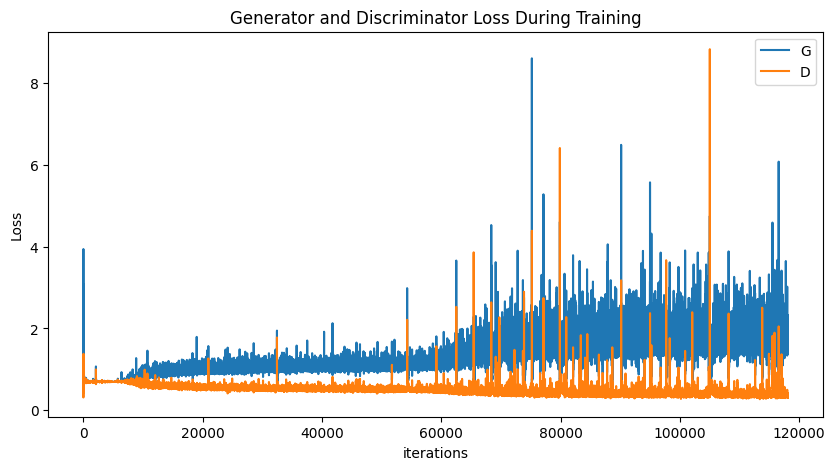

In [ ]:
## Results

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

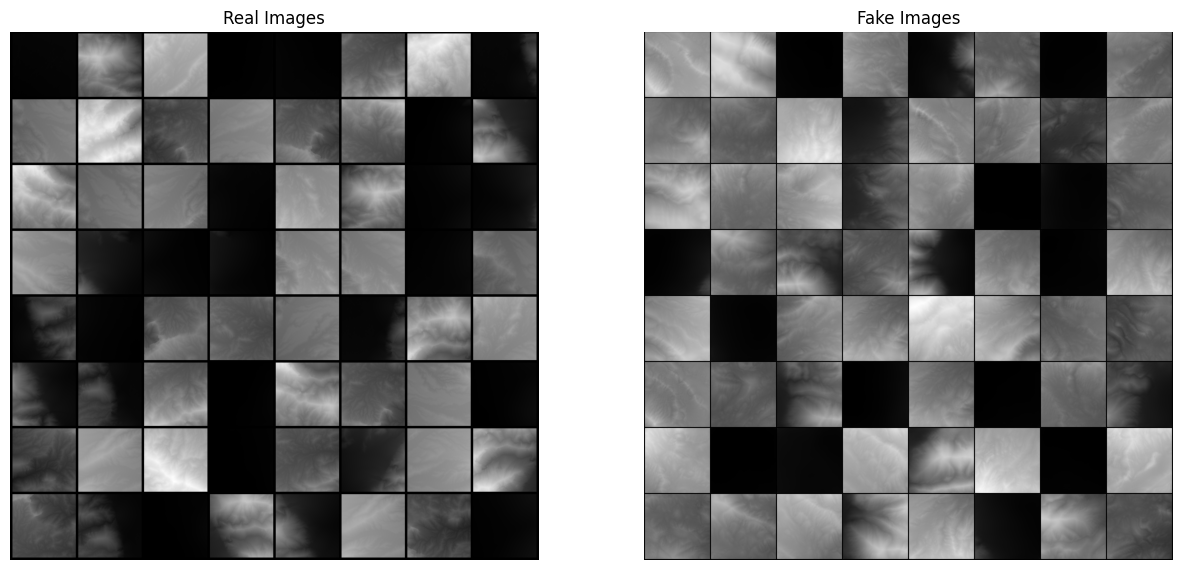

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()